# Transfer a GemPy model into a pyGIMLI mesh

First we create a new 3D-model in GemPy. For this case I use the example model provided in the GemPy tutorial notebooks

In [1]:
# Importing GemPy
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Setting options
np.random.seed(1515)
pd.set_option('precision', 2)

In [2]:
#Loading data and initializing model
geo_model = gp.create_model('Tutorial_ch1_1_Basics')

# %%
data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'

# Importing the data from CSV-files and setting extent and resolution
gp.init_data(geo_model, [0, 2000., 0, 2000., 0, 750.], [50, 50, 50],
             path_o=data_path + "/data/input_data/getting_started/"
                                "simple_fault_model_orientations.csv",
             path_i=data_path + "/data/input_data/getting_started/"
                                "simple_fault_model_points.csv",
             default_values=True)

Active grids: ['regular']


Tutorial_ch1_1_Basics  2020-06-10 17:24

In [3]:
#Mapping surfaces and marking the fault as a fault
gp.map_stack_to_surfaces(geo_model,
                         {"Fault_Series": 'Main_Fault',
                          "Strat_Series": ('Sandstone_2', 'Siltstone',
                                           'Shale', 'Sandstone_1', 'basement')},
                         remove_unused_series=True)
geo_model.set_is_fault(['Fault_Series'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault_Series,1,Fault,True,True,False
Strat_Series,2,Erosion,True,False,False


Before the model is computed, we need to define some 2D-cross sections that we want to transfer to a GIMLI mesh later:

In [4]:
section_dict = {'section1': ([0, 800], [2000, 800], [100, 80]),
                'section2': ([800, 0], [800, 2000], [150, 100]),
                'section3': ([0, 200], [1500, 500], [200, 150])}  # p1,p2,resolution
geo_model.set_section_grid(section_dict)

Active grids: ['regular' 'sections']


,start,stop,resolution,dist
section1,"[0, 800]","[2000, 800]","[100, 80]",2000.00
section2,"[800, 0]","[800, 2000]","[150, 100]",2000.00
section3,"[0, 200]","[1500, 500]","[200, 150]",1529.71


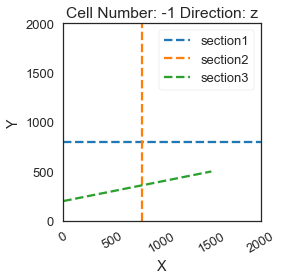

In [5]:
%matplotlib inline
gp.plot.plot_section_traces(geo_model)
plt.show()

Now we are ready to compute the model

In [6]:
#Compiling THEANO functions
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_run',
                    )

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                   values
range            2.9e+03
$C_o$              2e+05
drift equations   [3, 3]


In [7]:
#Computing the model
sol = gp.compute_model(geo_model)

### A look at one of the cross sections:

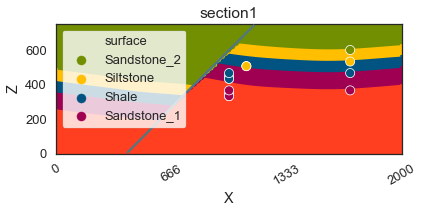

In [10]:
gp.plot_2d(geo_model, section_names=['section1'])

## Transfer the cross section to pyGIMLI

The next function provides the transfer of the geometry seen in the cross-section above to a pyGIMLI framework as a piecewise linear complex (PLC). These can easily be saved and loaded with pyGIMLI and used to create unstructured meshes for physical forward calculaions, inversions and other finite element modelling (Darcy flow, heat flow,...).

This is currently achieved by leveraging a GemPy 'section_utils' method, which outputs the 2D-coordinates of the interpolated surfaces as a matplotlib path as of GemPy 2.2.2. The vertices of the path are used to create polygons inside a pyGIMLI world which are marked by integers, referring to the lithological units in the model.

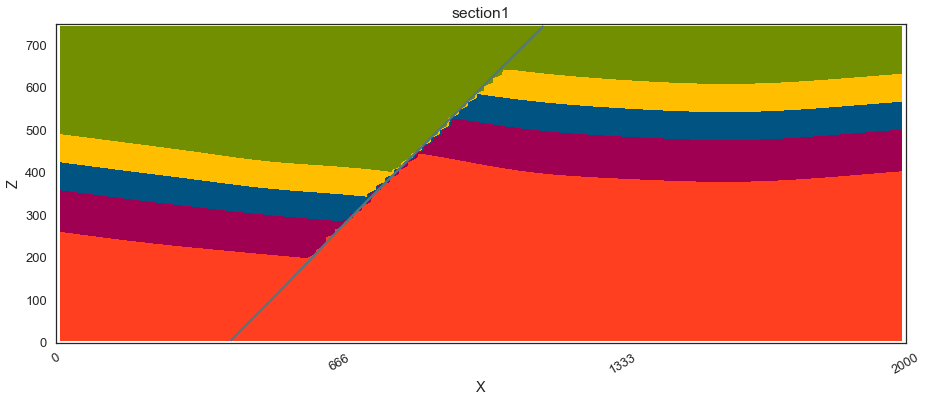

In [16]:
import pygimli as pg
import pygimli.meshtools as mt
from matplotlib.patches import PathPatch 
from gempy.core.grid_modules import section_utils

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (20,20)
%matplotlib inline

#THIS FUNCTION TAKES A GEMPY MODEL AND PREDEFINED CROSS SECTION
#TO TRANSFER INTO A PYGIMLI-COMPATIBLE PIECEWISE LINEAR COMPLEX (PLC)
def get_geometry(model,section,ignore = [], show = True, zshift = 0, save = None):
    '''model: interpolated GemPy model
       section: predefined cross section in the model
       ignore: list of surfaces that should be excluded from the GIMLI world. Currently the inclusion of faults
       can lead to faulty behaviour when the GIMLI regions are defined.
       show (True): show GIMLI world if True
       zshift: shifts model coordinates downwards by specified amount, sets highest point of PLC at z = 0 if True
       save (None): saves PLC into specified location if not None'''
    
    #First we get the polygon paths from GemPy and order them as MPL Patches in a new dictionary
    verts,colors,extent = section_utils.get_polygon_dictionary(model, section)
    geoms = {form:PathPatch(path[0]) for form,path in verts.items()} 
    
    #Now we get the overall min & max coordinate values to pass the correct bounds (GemPy's extent output includes the model boundaries, the vertex dictionary does not)
    allv = [i.get_verts() for i in geoms.values()] 
    
    xmax = max([max(i[:,0]) for i in allv])
    xmin = min([min(i[:,0]) for i in allv])
    zmax = max([max(i[:,1]) for i in allv])
    zmin = min([min(i[:,1]) for i in allv])
    
    #Setting up vertical shift of the model
    if zshift == True:
        zshift = zmax
        zmin -= zmax
        zmax = 0
    else:
        zmax -= zshift
        zmin -= zshift
        
    
    #Storing in an upper left, lower right-corner list
    realbounds = [[xmin,zmax],[xmax,zmin]]
    
    #Creating empty GIMLI world with the correct boundaries
    world = mt.createWorld((xmin,zmax),(xmax,zmin))
    unit_count = 0 #Counter to correctly mark the regions

    #Looping through the verts dictionary that contains the vertices of each unit
    #Currently using the MPL paths instead of the patches because they offer some features that might come in handy
    for name,unit in verts.items():
        if name not in ignore:
            unit_count += 1
            to_world = np.array([nde[0] for nde in unit[0].iter_segments()])
            to_world[:,1] -= zshift
            
            #Remove redundant end nodes
            if (to_world[0] == to_world[-1]).all():
                    to_world = np.delete(to_world,-1,axis=0)
                    
            #Add surface nodes to pyGIMLI world as a new polygon     
            world += mt.createPolygon(to_world, isClosed = True, marker = unit_count)
    
    if show == True:
        pg.show(world)
        
    if save is not None:
        mt.exportPLC(world, save)
        
    return world

    
world = get_geometry(geo_model,'section1',ignore = ['Main_Fault'],zshift = True, show = False)       


Above the gempy-cross section is seen. Below, the PLC inside pyGIMLI is shown, which can then easily be converted into a mesh. There are some odd artefacts along the fault surface (not shown below) which are due to the interpolation in GemPy

(<matplotlib.axes._subplots.AxesSubplot at 0x1492840d0>, None)

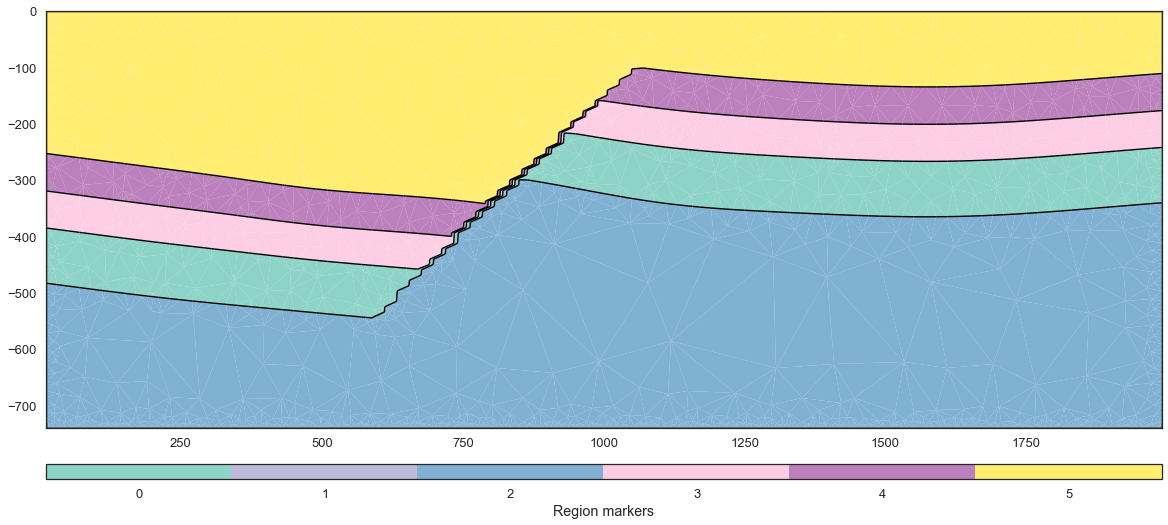

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))   
pg.show(world, ax=ax)

(<matplotlib.axes._subplots.AxesSubplot at 0x141e656d0>,
 <matplotlib.colorbar.Colorbar at 0x14ccca2d0>)

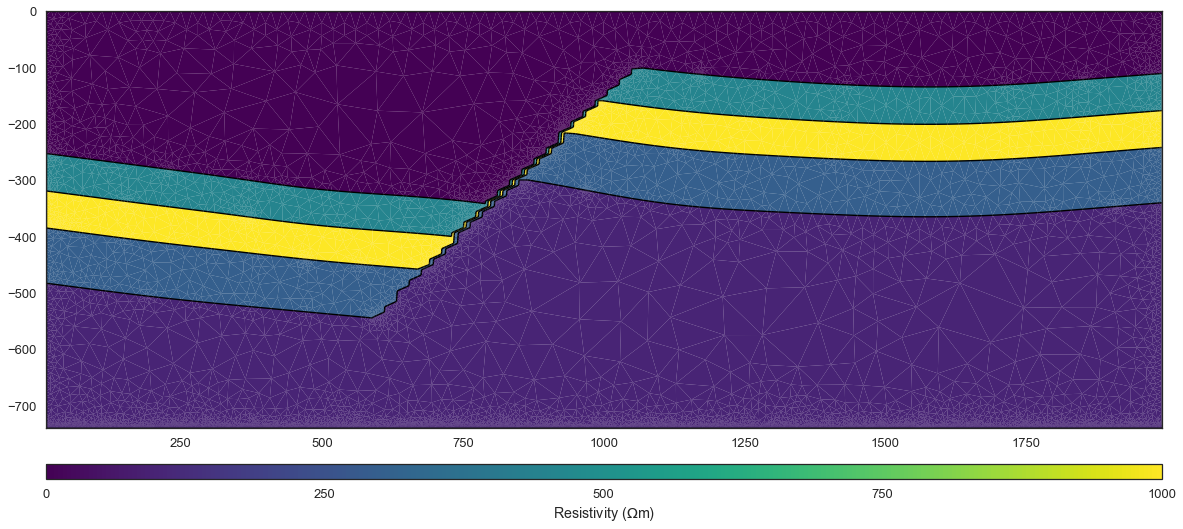

In [21]:
#Making an exemplary mesh, this could be used for ERT forward simulations or as a starting model for an inversion
rhomap = [[0,300],
          [1,500],  #Mapping typical resistance values to units
          [2,100],
          [3,1000],
          [4,450]] 

mesh = mt.createMesh(world)
fig, ax = plt.subplots(figsize=(20, 20))   
pg.show(mesh, ax=ax, data = rhomap, label = pg.unit('res'), colorBar =True)